### Importing the necessary libraries

In [1]:
import yfinance as yf

In [2]:
sony_info = yf.Ticker("SONY")
sony_history = sony_info.history(period="max")

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GRU

In [32]:
# CONSTANT PARAMETERS
EPOCH_COUNT = 40
BATCH_SIZE = 32

### Plot closing price data over time

In [6]:
# Get closing price column from the dataframe
closing_price_data = sony_history.iloc[:,3:4]
closing_price_data = closing_price_data.rename(columns={"Close": "Closing Price"})
closing_price_data.head()

,Closing Price
Date,
1973-02-21 00:00:00-05:00,5.828178
1973-02-22 00:00:00-05:00,5.691688
1973-02-23 00:00:00-05:00,5.582496
1973-02-26 00:00:00-05:00,5.500597
1973-02-27 00:00:00-05:00,5.377756


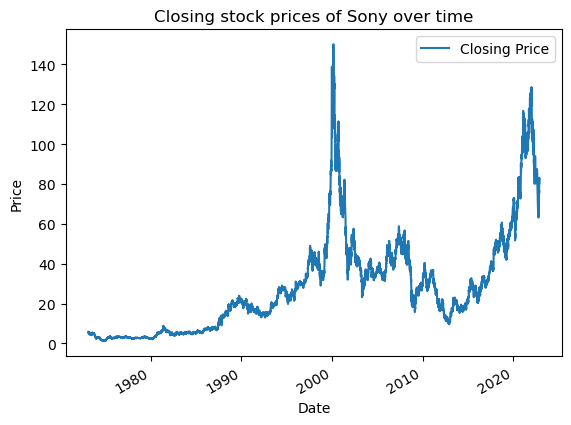

In [7]:
# Plot the closing stock price data
closing_price_data.plot()
plt.ylabel("Price")
plt.title("Closing stock prices of Sony over time")
plt.show()

### Scale the data

In [8]:
# Scale the data using Min-Max scaling to reduce computational cost.
scaler = MinMaxScaler()
closing_price_data_scaled = scaler.fit_transform(closing_price_data)

# The following logical comparison concludes that there are no NaN values.
len(closing_price_data.isna()) == len(closing_price_data)
closing_price_data_scaled_df = pd.DataFrame(closing_price_data_scaled)
closing_price_data_scaled_df.index = closing_price_data.index
closing_price_data_scaled_df = closing_price_data_scaled_df.rename(columns={0:"Closing Price"})
closing_price_data_scaled_df.head()

,Closing Price
Date,
1973-02-21 00:00:00-05:00,0.031057
1973-02-22 00:00:00-05:00,0.030140
1973-02-23 00:00:00-05:00,0.029407
1973-02-26 00:00:00-05:00,0.028857
1973-02-27 00:00:00-05:00,0.028032


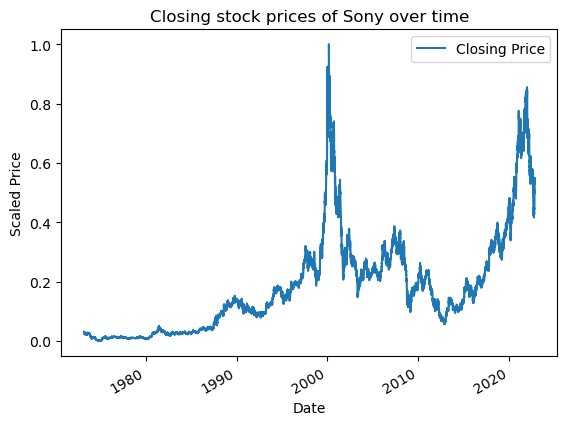

In [9]:
# Plot the scaled closing stock price data
closing_price_data_scaled_df.plot()
plt.ylabel("Scaled Price")
plt.title("Closing stock prices of Sony over time")
plt.show()

### Creation of train data and label sequences

In [83]:
# Function to generate train sample and test label sequences
def get_data_splits(data, train_size = 20, label_count = 1):
    train_sets = np.empty((0, train_size))
    labels = np.empty((0, label_count))
    length = len(data)
    for i in range(0, length):
        if (i + train_size) >= length:
            break
        # # ----------Debugging code start-----------------------------------------
        # print("Train: ", i, "to", i + train_size - 1)
        # print("Predict: ", (i + train_size), "to",
        #       (i + train_size + label_count - 1))
        # # ----------Debugging code end-------------------------------------------
        train_sets = np.append(
            train_sets, [data[i:(i + train_size)].reshape(train_size,)], axis=0)
        labels = np.append(labels, [data[(
            i + train_size):(i + train_size + label_count)].reshape(label_count,)], axis=0)

    return train_sets.reshape(len(train_sets), train_size, 1), labels.reshape(len(labels), label_count, 1)


In [11]:
# Splitting the dataset
length = len(closing_price_data_scaled)
train_sample_count = round(0.60 * length)
remaining_sample_count = length - train_sample_count
val_sample_count = round(0.50 * remaining_sample_count)

training_set = closing_price_data_scaled[0:train_sample_count]
validation_set = closing_price_data_scaled[train_sample_count:(
    train_sample_count + val_sample_count)]
testing_set = closing_price_data_scaled[(
    train_sample_count + val_sample_count):length]

In [12]:
len(training_set), len(validation_set), len(testing_set)

(7529, 2510, 2510)

In [13]:
# Get the train features, train labels, test features, test labels
train_size = 20
label_count = 1
X_train, y_train = get_data_splits(training_set, train_size, label_count)
X_val, y_val = get_data_splits(validation_set, train_size, label_count)
X_test, y_test = get_data_splits(testing_set, train_size, label_count)

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

7509 7509
2490 2490
2490 2490


### Some helper functions

In [250]:
def plot_training_history(fitted_model):
    # Training/validation loss and accuracy curve
    pd.DataFrame(fitted_model.history).plot()
    plt.xlabel("Number of epochs")
    plt.ylabel("Loss - Accuracy")
    plt.tight_layout()
    plt.show()

def plot_result(y_train, y_test, train_predict, test_predict, second_stock_y=np.array([])):
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 8), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    if len(second_stock_y) != 0:
        plt.plot(range(rows), second_stock_y)
        plt.legend(['Actual', 'Predictions', 'AMD'])
    else:
        plt.legend(['Actual', 'Predictions'])
    plt.axvline(x=len(y_train), color='r')
    plt.xlabel('Days')
    plt.ylabel('Stock price')
    plt.title(
        'Actual and Predicted Values. The Red Line Separates The Training And Test Examples')


### Base GRU

In [15]:
def create_simple_GRU(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

n_hidden_units = 64
n_dense_units = 1
input_shape = (train_size, 1)

In [16]:
# Create base GRU model
simple_gru = create_simple_GRU(n_hidden_units, n_dense_units,
                         input_shape, activation='tanh')
simple_gru.summary()

# Training the vanilla RNN
with tf.device('/cpu:0'):
    fitted_simple_gru = simple_gru.fit(
        X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


2022-11-19 16:43:09.347854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-19 16:43:09.347956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-19 16:43:09.523274: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-19 16:43:09.949645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.0010

2022-11-19 16:43:11.891998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 8ms/step - loss: 0.0010 - val_loss: 1.0082e-04
Epoch 2/40
235/235 [==============================] - 2s 7ms/step - loss: 1.3803e-04 - val_loss: 1.2151e-04
Epoch 3/40
235/235 [==============================] - 2s 7ms/step - loss: 1.0945e-04 - val_loss: 4.9894e-05
Epoch 4/40
235/235 [==============================] - 2s 7ms/step - loss: 9.4439e-05 - val_loss: 3.9993e-05
Epoch 5/40
235/235 [==============================] - 2s 7ms/step - loss: 9.5120e-05 - val_loss: 3.7227e-05
Epoch 6/40
235/235 [==============================] - 2s 7ms/step - loss: 8.2254e-05 - val_loss: 3.4476e-05
Epoch 7/40
235/235 [==============================] - 2s 7ms/step - loss: 7.8973e-05 - val_loss: 4.3213e-05
Epoch 8/40
235/235 [==============================] - 2s 7ms/step - loss: 7.7605e-05 - val_loss: 5.2340e-05
Epoch 9/40
235/235 [==============================] - 2s 7ms/step - loss: 7.0886e-05 - val_loss: 5.9244e-05
Epoch 10/40
235/235 [======================

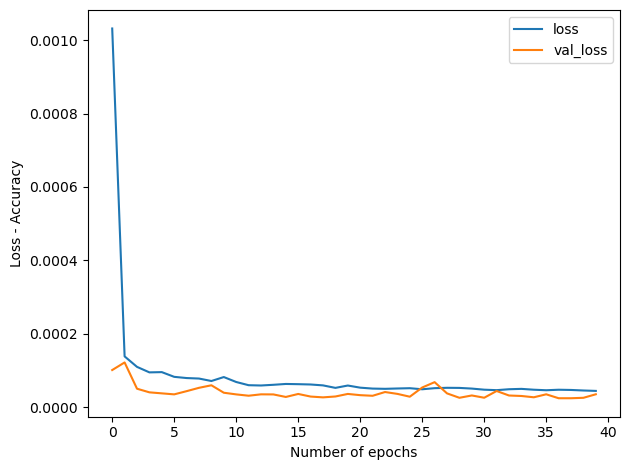

In [33]:
plot_training_history(fitted_simple_gru)

 42/235 [====>.........................] - ETA: 0s

2022-11-19 16:44:20.604906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 0s 2ms/step


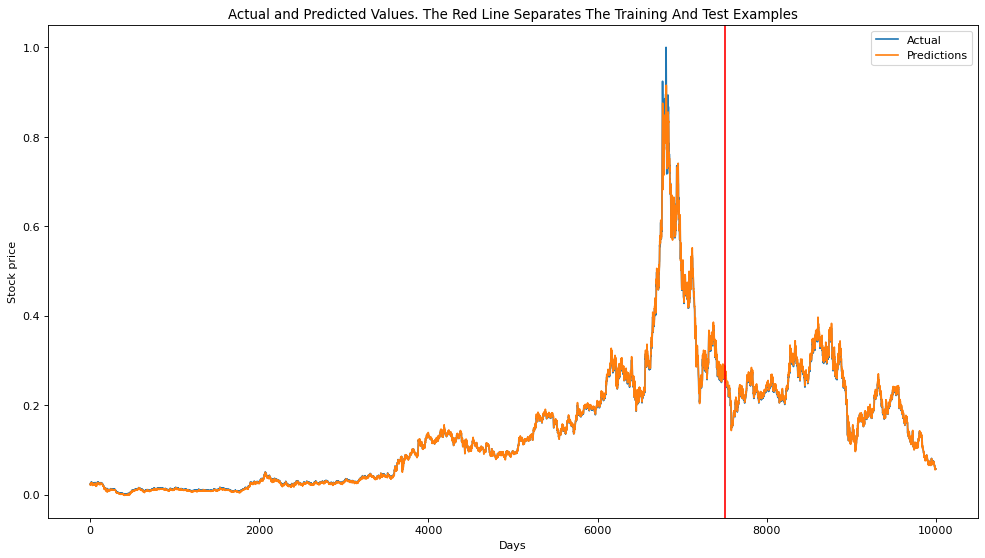

In [18]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_simple_gru = fitted_simple_gru.model.predict(X_train)
    val_predict_simple_gru = fitted_simple_gru.model.predict(X_val)
plot_result(y_train, y_val, train_predict_simple_gru, val_predict_simple_gru)


### Experimentation on simple GRU

##### Adding more layers

In [19]:
# Creating RNN with multiple layers
def create_GRU_1(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(GRU(hidden_units_list[0], input_shape=input_shape,
                        activation=activation, return_sequences=True))
    for i in range(1, len(hidden_units_list)):
        if i == len(hidden_units_list) - 1:
            model.add(GRU(hidden_units_list[i], activation=activation,
                      return_sequences=False))
        else:
            model.add(GRU(hidden_units_list[i], activation=activation,
                      return_sequences=True))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',
                  optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (train_size, 1)

In [20]:
gru_1 = create_GRU_1(n_hidden_units_list, n_dense_units,
                   input_shape, activation='tanh')
gru_1.summary()

# Training the RNN with multiple SimpleRNN layers
with tf.device('/cpu:0'):
    fitted_gru_1 = gru_1.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 20, 64)            12864     
                                                                 
 gru_2 (GRU)                 (None, 20, 64)            24960     
                                                                 
 gru_3 (GRU)                 (None, 64)                24960     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 62,849
Trainable params: 62,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


2022-11-19 16:44:23.020230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/235 [============================>.] - ETA: 0s - loss: 0.0010

2022-11-19 16:44:28.156796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 7s 21ms/step - loss: 0.0010 - val_loss: 2.1483e-04
Epoch 2/40
235/235 [==============================] - 4s 19ms/step - loss: 1.6696e-04 - val_loss: 1.0460e-04
Epoch 3/40
235/235 [==============================] - 4s 19ms/step - loss: 1.2040e-04 - val_loss: 9.4219e-05
Epoch 4/40
235/235 [==============================] - 5s 19ms/step - loss: 1.1398e-04 - val_loss: 7.0789e-05
Epoch 5/40
235/235 [==============================] - 5s 19ms/step - loss: 8.6968e-05 - val_loss: 5.8268e-05
Epoch 6/40
235/235 [==============================] - 5s 19ms/step - loss: 8.0001e-05 - val_loss: 5.7104e-05
Epoch 7/40
235/235 [==============================] - 5s 19ms/step - loss: 7.8637e-05 - val_loss: 3.6920e-05
Epoch 8/40
235/235 [==============================] - 5s 19ms/step - loss: 8.0033e-05 - val_loss: 1.5744e-04
Epoch 9/40
235/235 [==============================] - 5s 19ms/step - loss: 6.8392e-05 - val_loss: 3.2888e-05
Epoch 10/40
235/235 [=============

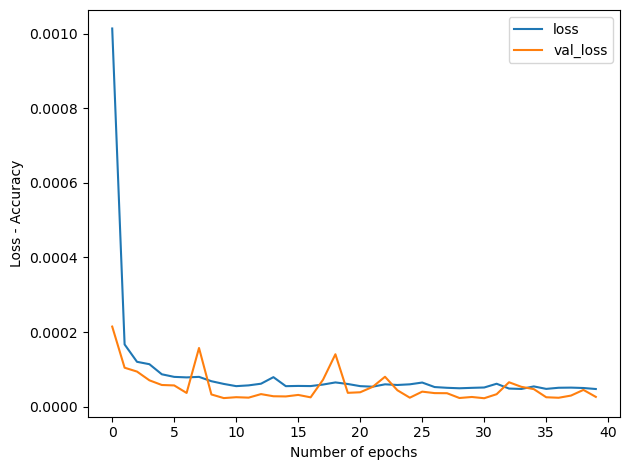

In [34]:
plot_training_history(fitted_gru_1)

  1/235 [..............................] - ETA: 1:34

2022-11-19 16:47:26.735324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 7ms/step


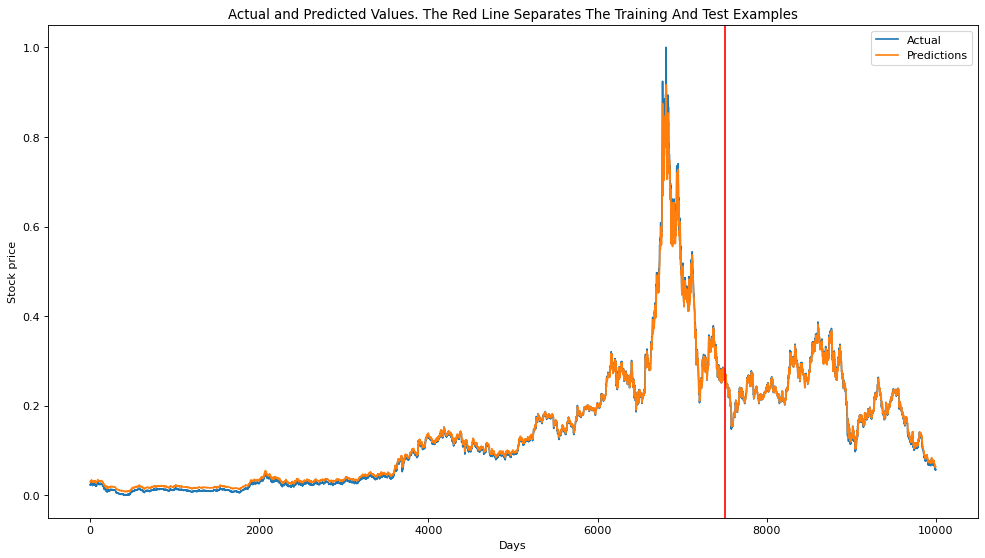

In [22]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_gru_1 = fitted_gru_1.model.predict(X_train)
    val_predict_gru_1 = fitted_gru_1.model.predict(X_val)
plot_result(y_train, y_val, train_predict_gru_1, val_predict_gru_1)

##### Experimenting with the activation function and learning rate scheduling techniques.

In [23]:
import math

# Function to experiment with optimizer and learning rate.
def create_GRU_2(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = 0
    if optimizer == "Adam":
        optimizing_function = keras.optimizers.Adam()
    else:
        optimizing_function = keras.optimizers.RMSprop()

    model.compile(loss='mean_squared_error',
                  optimizer=optimizing_function)
    return model


initial_learning_rate = 0.01
time_decay = initial_learning_rate / EPOCH_COUNT

# Step decay for learning rate
def step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# Exponential decay for learning rate
def exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)


callbacks_decay = [keras.callbacks.LearningRateScheduler(step_decay, verbose=1),
    keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)]
callback_decay_keys = ["constant", "step_decay", "exp_decay"]

In [38]:
'''
Running the simple GRU model with RMSProp and Adam with 3 different types of learning rate
scheduling.
'''
n_hidden_units = 64
n_dense_units = 1
results_simple_gru = []
optimizers = ["Adam", "RMSProp"]
for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        model = create_GRU_2(n_hidden_units, n_dense_units,
                            input_shape, activation='tanh', optimizer=optimizer)
        # Training the RNN with multiple SimpleRNN layers
        fitted_model = 0
        with tf.device('/cpu:0'):
            if i == 0:
                fitted_model = model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)
            else:
                fitted_model = model.fit(X_train, y_train, validation_data=(
                    X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, callbacks=[callbacks_decay[i - 1]])

        predictions = fitted_model.model.predict(X_val)
        val_mse = mean_squared_error(
            y_val.reshape(y_val.shape[0], 1), predictions)
        results_simple_gru.append(
            (optimizer, callback_decay_keys[i], val_mse))


Epoch 1/40


2022-11-19 19:43:23.244530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


231/235 [============================>.] - ETA: 0s - loss: 0.0013

2022-11-19 19:43:25.755378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 11ms/step - loss: 0.0013 - val_loss: 1.1212e-04
Epoch 2/40
235/235 [==============================] - 3s 12ms/step - loss: 1.3278e-04 - val_loss: 4.8823e-05
Epoch 3/40
235/235 [==============================] - 2s 10ms/step - loss: 1.1302e-04 - val_loss: 4.5892e-05
Epoch 4/40
235/235 [==============================] - 3s 11ms/step - loss: 1.0310e-04 - val_loss: 3.9781e-05
Epoch 5/40
235/235 [==============================] - 2s 9ms/step - loss: 8.6944e-05 - val_loss: 4.1591e-05
Epoch 6/40
235/235 [==============================] - 2s 10ms/step - loss: 9.3771e-05 - val_loss: 3.7611e-05
Epoch 7/40
235/235 [==============================] - 2s 9ms/step - loss: 7.8172e-05 - val_loss: 5.8674e-05
Epoch 8/40
235/235 [==============================] - 2s 9ms/step - loss: 7.7163e-05 - val_loss: 5.7774e-05
Epoch 9/40
235/235 [==============================] - 3s 11ms/step - loss: 7.1391e-05 - val_loss: 3.2770e-05
Epoch 10/40
235/235 [================

2022-11-19 19:44:09.338658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:44:09.429860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:44:10.219441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 2s 23ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2022-11-19 19:44:11.493386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


231/235 [============================>.] - ETA: 0s - loss: 8.3613e-04

2022-11-19 19:44:13.851805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 10ms/step - loss: 8.2367e-04 - val_loss: 4.1195e-05 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 8.8689e-05 - val_loss: 4.3557e-05 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 7.3643e-05 - val_loss: 5.5648e-05 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/40
235/235 [==============================] - 2s 9ms/step - loss: 7.4730e-05 - val_loss: 5.1660e-05 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/40
235/235 [==============================] - 2s 10ms/step - loss: 8.2186e-05 - val_loss: 8.3534e-05 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/40
235/235 [==============================] - 2s 9ms/step - loss: 6.2448e-05 - va

2022-11-19 19:45:41.983965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:45:42.037222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 6ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2022-11-19 19:45:43.195238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


232/235 [============================>.] - ETA: 0s - loss: 4.4902e-04

2022-11-19 19:45:45.540412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 11ms/step - loss: 4.4430e-04 - val_loss: 1.0097e-04 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 8.8022e-05 - val_loss: 2.9504e-05 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 6.4791e-05 - val_loss: 5.4483e-05 - lr: 0.0082

Epoch 4: LearningRateScheduler setting learning rate to 0.007408182206817179.
Epoch 4/40
235/235 [==============================] - 2s 9ms/step - loss: 7.9243e-05 - val_loss: 2.7605e-05 - lr: 0.0074

Epoch 5: LearningRateScheduler setting learning rate to 0.006703200460356393.
Epoch 5/40
235/235 [==============================] - 2s 9ms/step - loss: 5.7334e-05 - val_loss: 4.2734e-05 - lr: 0.0067

Epoch 6: LearningRateScheduler setting learning rate to 0.006065306597126334.
Epoch 6/40

2022-11-19 19:47:01.965674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:47:02.004539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 5ms/step
Epoch 1/40


2022-11-19 19:47:02.925499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


229/235 [============================>.] - ETA: 0s - loss: 0.0014

2022-11-19 19:47:05.199932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 10ms/step - loss: 0.0014 - val_loss: 4.0659e-04
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 2.4970e-04 - val_loss: 6.4048e-05
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 1.9342e-04 - val_loss: 2.8419e-04
Epoch 4/40
235/235 [==============================] - 2s 9ms/step - loss: 1.6324e-04 - val_loss: 1.9412e-04
Epoch 5/40
235/235 [==============================] - 2s 9ms/step - loss: 1.4481e-04 - val_loss: 7.0784e-05
Epoch 6/40
235/235 [==============================] - 2s 9ms/step - loss: 1.2258e-04 - val_loss: 3.5856e-05
Epoch 7/40
235/235 [==============================] - 2s 9ms/step - loss: 1.1644e-04 - val_loss: 3.1881e-05
Epoch 8/40
235/235 [==============================] - 2s 9ms/step - loss: 1.0725e-04 - val_loss: 4.5450e-05
Epoch 9/40
235/235 [==============================] - 2s 9ms/step - loss: 9.9610e-05 - val_loss: 3.3644e-05
Epoch 10/40
235/235 [=====================

2022-11-19 19:48:25.336255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:48:25.373947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 4ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2022-11-19 19:48:26.288271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


229/235 [============================>.] - ETA: 0s - loss: 0.0028

2022-11-19 19:48:28.554678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 10ms/step - loss: 0.0027 - val_loss: 8.1529e-04 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 6.7988e-04 - val_loss: 6.7056e-04 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 4.6246e-04 - val_loss: 3.3770e-05 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/40
235/235 [==============================] - 2s 9ms/step - loss: 3.2753e-04 - val_loss: 1.0975e-04 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/40
235/235 [==============================] - 2s 9ms/step - loss: 3.9863e-04 - val_loss: 1.6192e-04 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/40
235/235 [==============================] - 2s 9ms/step - loss: 4.8681e-04 - val_los

2022-11-19 19:49:48.691335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:49:48.727843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 5ms/step

Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/40


2022-11-19 19:49:49.650373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.0028

2022-11-19 19:49:51.917903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 3s 10ms/step - loss: 0.0028 - val_loss: 7.0092e-04 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 4.7016e-04 - val_loss: 2.8877e-04 - lr: 0.0090

Epoch 3: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 2.7652e-04 - val_loss: 7.2856e-04 - lr: 0.0082

Epoch 4: LearningRateScheduler setting learning rate to 0.007408182206817179.
Epoch 4/40
235/235 [==============================] - 2s 9ms/step - loss: 2.0420e-04 - val_loss: 4.9504e-04 - lr: 0.0074

Epoch 5: LearningRateScheduler setting learning rate to 0.006703200460356393.
Epoch 5/40
235/235 [==============================] - 2s 9ms/step - loss: 1.5830e-04 - val_loss: 4.0718e-05 - lr: 0.0067

Epoch 6: LearningRateScheduler setting learning rate to 0.006065306597126334.
Epoch 6/40
235

2022-11-19 19:51:12.051108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-19 19:51:12.087627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 1s 5ms/step


In [264]:
df = pd.DataFrame(results_simple_gru)
df

,0,1,2
0,Adam,constant,0.000031
1,Adam,step_decay,0.002149
2,Adam,exp_decay,0.000722
3,RMSProp,constant,0.000053
4,RMSProp,step_decay,0.007024
5,RMSProp,exp_decay,0.005502


In [266]:
# Based on the above results, Adam with constant learning rate was the best.
optimized_gru_2 = create_GRU_2(n_hidden_units, n_dense_units,
                                 input_shape, activation='tanh', optimizer=keras.optimizers.Adam())

with tf.device('/cpu:0'):
    fitted_optimized_gru_2 = optimized_gru_2.fit(X_train, y_train, validation_data=(
        X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)

Epoch 1/40


2022-11-23 22:49:15.964212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


230/235 [============================>.] - ETA: 0s - loss: 8.0918e-04

2022-11-23 22:49:19.784754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 5s 16ms/step - loss: 7.9747e-04 - val_loss: 5.8819e-05
Epoch 2/40
235/235 [==============================] - 2s 9ms/step - loss: 2.3244e-04 - val_loss: 4.8259e-05
Epoch 3/40
235/235 [==============================] - 2s 9ms/step - loss: 1.9084e-04 - val_loss: 8.8851e-05
Epoch 4/40
235/235 [==============================] - 2s 9ms/step - loss: 1.6060e-04 - val_loss: 2.2345e-04
Epoch 5/40
235/235 [==============================] - 2s 9ms/step - loss: 1.4692e-04 - val_loss: 1.7061e-04
Epoch 6/40
235/235 [==============================] - 2s 9ms/step - loss: 1.2592e-04 - val_loss: 1.7811e-04
Epoch 7/40
235/235 [==============================] - 2s 9ms/step - loss: 1.2234e-04 - val_loss: 3.2662e-05
Epoch 8/40
235/235 [==============================] - 2s 9ms/step - loss: 1.1633e-04 - val_loss: 1.1248e-04
Epoch 9/40
235/235 [==============================] - 2s 9ms/step - loss: 1.0041e-04 - val_loss: 3.6694e-05
Epoch 10/40
235/235 [=================

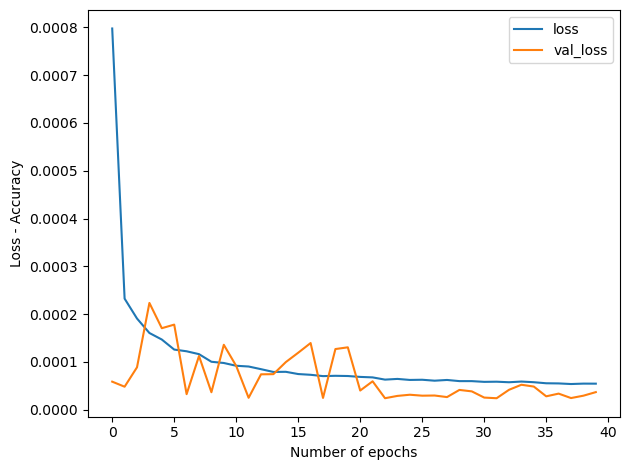

In [267]:
plot_training_history(fitted_optimized_gru_2)

78/78 [==============================] - 0s 3ms/step


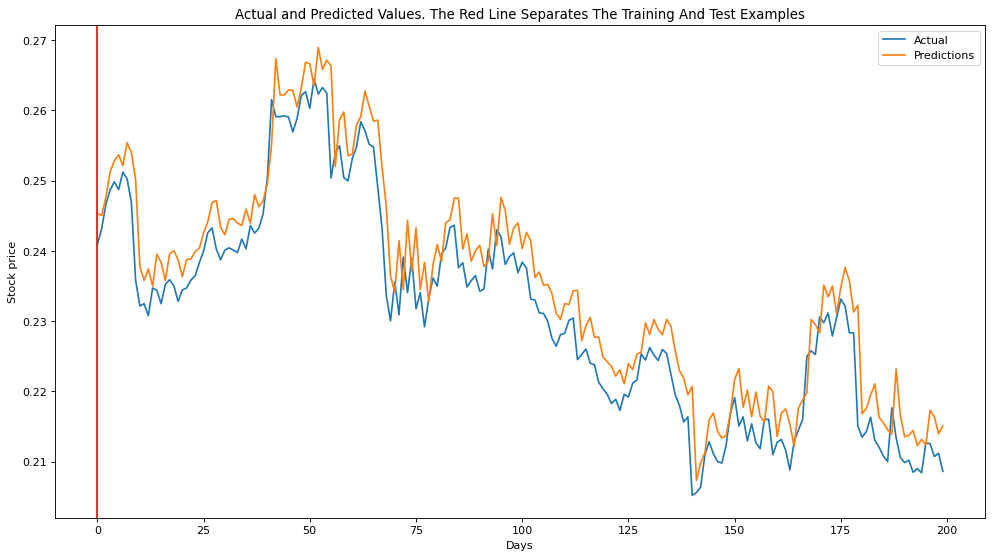

In [271]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_optimized_gru_2 = fitted_optimized_gru_2.model.predict(
        X_train)
    val_predict_optimized_gru_2 = fitted_optimized_gru_2.model.predict(X_val)
# plot_result(y_train, y_val, train_predict_optimized_gru_2,
#             val_predict_optimized_gru_2)
plot_result(np.array([]), y_val[500:700], np.array([]),
            val_predict_optimized_gru_2[500:700])


### Performance metrics

In [269]:
# Get training and validation MSEs for all variations of the RNN
train_mse_simple_gru, val_mse_simple_gru = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_simple_gru), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_simple_gru)

train_mse_gru_1, val_mse_gru_1 = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_gru_1), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_gru_1)

train_mse_optimized_gru_2, val_mse_optimized_gru_2 = mean_squared_error(
    y_train.reshape(y_train.shape[0], 1), train_predict_optimized_gru_2), mean_squared_error(y_val.reshape(y_val.shape[0], 1), val_predict_optimized_gru_2)

In [270]:
gru_summary = [("Simple GRU", train_mse_simple_gru, val_mse_simple_gru),
                ("Stacked GRU", train_mse_gru_1,
                 val_mse_gru_1),
                ("Optimized stacked GRU", train_mse_optimized_gru_2, val_mse_optimized_gru_2)]

gru_summary_df = pd.DataFrame(
    gru_summary, columns=["Model", "Train MSE", "Val MSE"])
gru_summary_df


,Model,Train MSE,Val MSE
0,Simple GRU,0.000042,0.000035
1,Stacked GRU,0.000067,0.000026
2,Optimized simple GRU,0.000046,0.000037


### Experimentation with window size

(7479, 50, 1) (7479, 1, 1)
(2460, 50, 1) (2460, 1, 1)
Epoch 1/10


2022-11-20 19:27:30.873557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - ETA: 0s - loss: 6.9841e-04

2022-11-20 19:27:42.193657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - 14s 49ms/step - loss: 6.9841e-04 - val_loss: 7.3077e-05
Epoch 2/10
234/234 [==============================] - 11s 46ms/step - loss: 1.6412e-04 - val_loss: 6.8467e-05
Epoch 3/10
234/234 [==============================] - 11s 46ms/step - loss: 1.2965e-04 - val_loss: 7.4799e-05
Epoch 4/10
234/234 [==============================] - 11s 46ms/step - loss: 1.2781e-04 - val_loss: 8.1522e-05
Epoch 5/10
234/234 [==============================] - 11s 46ms/step - loss: 9.4089e-05 - val_loss: 4.2121e-05
Epoch 6/10
234/234 [==============================] - 11s 46ms/step - loss: 9.1174e-05 - val_loss: 2.8099e-05
Epoch 7/10
234/234 [==============================] - 11s 47ms/step - loss: 6.9622e-05 - val_loss: 1.5089e-04
Epoch 8/10
234/234 [==============================] - 11s 46ms/step - loss: 8.0307e-05 - val_loss: 2.9947e-05
Epoch 9/10
234/234 [==============================] - 11s 48ms/step - loss: 6.2866e-05 - val_loss: 2.4128e-05
Epoch 10/10
234/234 [

2022-11-20 19:29:20.872599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 1s 11ms/step


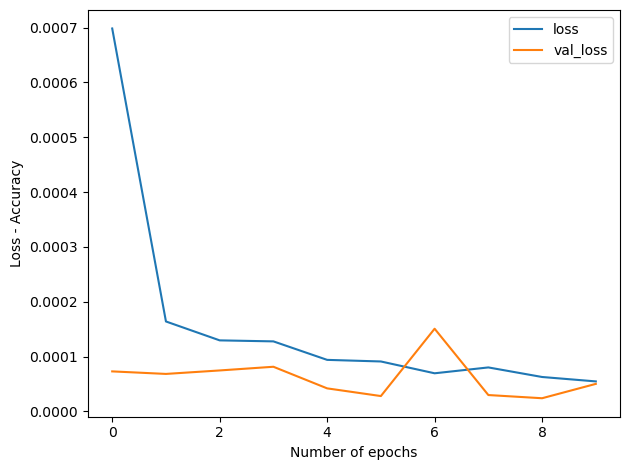

Val MSE = 5.0315001120772646e-05
(7429, 100, 1) (7429, 1, 1)
(2410, 100, 1) (2410, 1, 1)
Epoch 1/10


2022-11-20 19:29:28.614560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - ETA: 0s - loss: 8.9821e-04

2022-11-20 19:29:47.716233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


233/233 [==============================] - 22s 85ms/step - loss: 8.9821e-04 - val_loss: 1.0712e-04
Epoch 2/10
233/233 [==============================] - 19s 83ms/step - loss: 1.4944e-04 - val_loss: 6.0894e-05
Epoch 3/10
233/233 [==============================] - 19s 83ms/step - loss: 1.1772e-04 - val_loss: 9.6999e-05
Epoch 4/10
233/233 [==============================] - 19s 83ms/step - loss: 1.0385e-04 - val_loss: 6.0394e-05
Epoch 5/10
233/233 [==============================] - 19s 84ms/step - loss: 9.3656e-05 - val_loss: 3.7520e-05
Epoch 6/10
233/233 [==============================] - 20s 85ms/step - loss: 7.9604e-05 - val_loss: 6.2422e-05
Epoch 7/10
233/233 [==============================] - 20s 84ms/step - loss: 7.6077e-05 - val_loss: 7.1810e-05
Epoch 8/10
233/233 [==============================] - 20s 84ms/step - loss: 6.0895e-05 - val_loss: 2.6380e-05
Epoch 9/10
233/233 [==============================] - 20s 84ms/step - loss: 5.3502e-05 - val_loss: 3.8063e-05
Epoch 10/10
233/233 [

2022-11-20 19:32:44.536230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - 1s 18ms/step


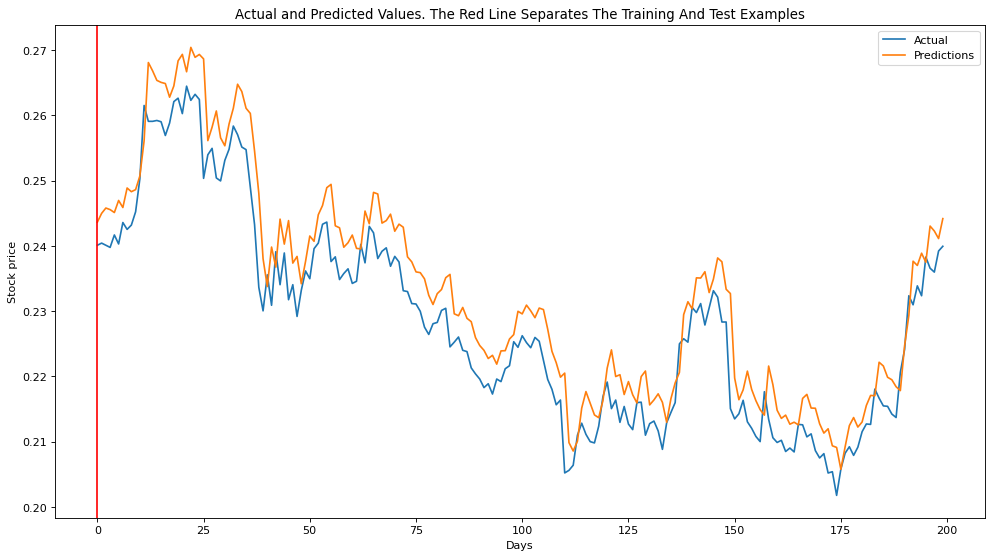

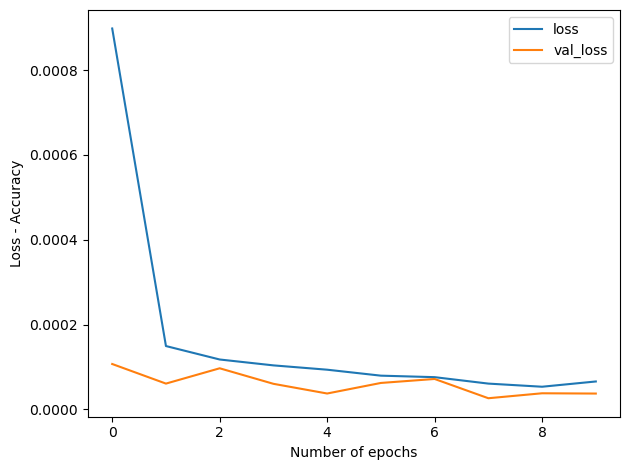

Val MSE = 3.741747232646642e-05


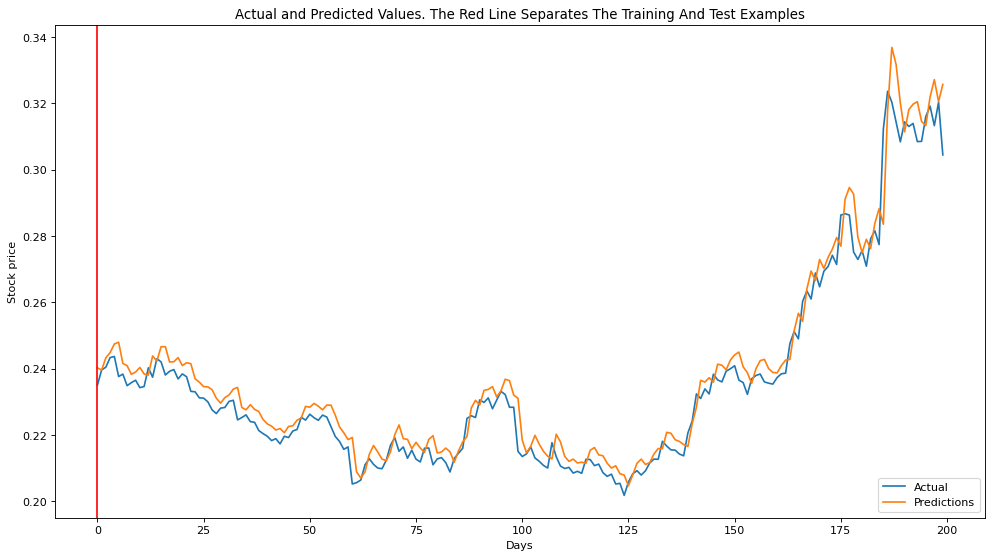

In [242]:
# Get the train features, train labels, test features, test labels
train_sizes = [50, 100]
label_count = 1

for train_size in train_sizes:
    X_train_e, y_train_e = get_data_splits(
        training_set, train_size, label_count)
    X_val_e, y_val_e = get_data_splits(
        validation_set, train_size, label_count)

    print(X_train_e.shape, y_train_e.shape)
    print(X_val_e.shape, y_val_e.shape)

    model = create_GRU_1([n_hidden_units, n_hidden_units, n_hidden_units], n_dense_units,
                             (train_size, 1), activation='tanh')
    with tf.device('/cpu:0'):
        fitted_model = model.fit(X_train_e, y_train_e, validation_data=(
            X_val_e, y_val_e), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT - 30)
        train_predict = fitted_model.model.predict(X_train_e)
        val_predict = fitted_model.model.predict(X_val_e)
    # Plotting actual stock prices and predictions
    plot_training_history(fitted_model)
    plot_result(np.array([]), y_val_e[500:700],
                np.array([]), val_predict[500:700])
    print("Val MSE =", mean_squared_error(
        y_val_e.reshape(y_val_e.shape[0], 1), val_predict))


### Multivariate GRU (using closing prices from stocks of two different companies)

In [55]:
amd_info = yf.Ticker("AMD")
amd_history = amd_info.history(period="max")

In [62]:
# Get closing price column from the dataframe
closing_price_data_amd = amd_history.iloc[:, 3:4]
closing_price_data_amd = closing_price_data_amd.rename(
    columns={"Close": "Closing Price"})
closing_price_data_amd.head()

,Closing Price
Date,
1980-03-17 00:00:00-05:00,3.145833
1980-03-18 00:00:00-05:00,3.031250
1980-03-19 00:00:00-05:00,3.041667
1980-03-20 00:00:00-05:00,3.010417
1980-03-21 00:00:00-05:00,2.916667


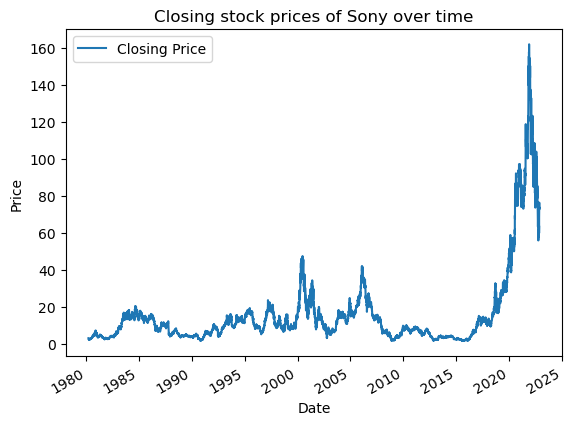

In [63]:
# Plot the closing stock price data
closing_price_data_amd.plot()
plt.ylabel("Price")
plt.title("Closing stock prices of Sony over time")
plt.show()

In [72]:
combined_price_data = pd.DataFrame()
difference = len(closing_price_data["Closing Price"]) - \
    len(closing_price_data_amd["Closing Price"])
combined_price_data["cp_sony"] = closing_price_data["Closing Price"].iloc[difference:]
combined_price_data["cp_amd"] = closing_price_data_amd["Closing Price"]
combined_price_data.head()

,cp_sony,cp_amd
Date,,
1980-03-17 00:00:00-05:00,2.279142,3.145833
1980-03-18 00:00:00-05:00,2.408149,3.031250
1980-03-19 00:00:00-05:00,2.408149,3.041667
1980-03-20 00:00:00-05:00,2.408149,3.010417
1980-03-21 00:00:00-05:00,2.451151,2.916667


In [82]:
# Scale the data using MinMax scaling
combined_price_data_scaled = scaler.fit_transform(combined_price_data)
combined_price_data_scaled.shape

(10763, 2)

In [229]:
# Function to generate train sample and test label sequences
def get_data_splits_2(data, train_size=20, label_count=1):
    train_sets = []
    labels = []
    data_list = []
    for each in data:
        row = [num for num in each]
        data_list.append(row)
    length = len(data_list)
    # print(data_list)
    for i in range(0, length):
        if (i + train_size) >= length:
            break
        # # ----------Debugging code start-----------------------------------------
        # print("Train: ", i, "to", i + train_size - 1)
        # print("Predict: ", (i + train_size), "to",
        #       (i + train_size + label_count - 1))
        # # ----------Debugging code end-------------------------------------------
        train_sets.append(data_list[i:(i + train_size)])
        labels.append([data_list[(i + train_size):(i + train_size + label_count)][0][0]])

    return np.array(train_sets).reshape(len(train_sets), train_size, 2), np.array(labels).reshape(len(labels), label_count, 1)

In [252]:
# Splitting the dataset
length_m = len(combined_price_data_scaled)
train_sample_count_m = round(0.60 * length_m)
remaining_sample_count_m = length_m - train_sample_count_m
val_sample_count_m = round(0.50 * remaining_sample_count_m)

training_set_m = combined_price_data_scaled[0:train_sample_count_m]
validation_set_m = combined_price_data_scaled[train_sample_count_m:(
    train_sample_count_m + val_sample_count_m)]
testing_set_m = combined_price_data_scaled[(
    train_sample_count_m + val_sample_count_m):length_m]

corresponding_y_amd_val = scaler.fit_transform(closing_price_data_amd)[train_sample_count_m:(
    train_sample_count_m + val_sample_count_m)]
corresponding_y_amd_test = scaler.fit_transform(closing_price_data_amd)[(
    train_sample_count_m + val_sample_count_m):length_m]


In [235]:
train_size = 20
label_count = 1
X_train_combined, y_train_combined = get_data_splits_2(
    training_set_m, train_size, label_count)
X_val_combined, y_val_combined = get_data_splits_2(
    validation_set_m, train_size, label_count)
X_test_combined, y_test_combined = get_data_splits_2(
    testing_set_m, train_size, label_count)


In [236]:
multivariate_model = create_simple_GRU(n_hidden_units, n_dense_units,
                                       (20, 2), activation='tanh')
multivariate_model.summary()

# Training the vanilla RNN
with tf.device('/cpu:0'):
    fitted_multivariate_model = multivariate_model.fit(
        X_train_combined, y_train_combined, validation_data=(X_val_combined, y_val_combined), batch_size=BATCH_SIZE, epochs=EPOCH_COUNT)


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_40 (GRU)                (None, 64)                13056     
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40


2022-11-20 17:11:02.802022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


201/202 [============================>.] - ETA: 0s - loss: 0.0027

2022-11-20 17:11:04.838139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


202/202 [==============================] - 3s 10ms/step - loss: 0.0027 - val_loss: 8.5297e-05
Epoch 2/40
202/202 [==============================] - 2s 8ms/step - loss: 1.7233e-04 - val_loss: 5.2717e-05
Epoch 3/40
202/202 [==============================] - 2s 8ms/step - loss: 1.4128e-04 - val_loss: 8.5334e-05
Epoch 4/40
202/202 [==============================] - 2s 8ms/step - loss: 1.2985e-04 - val_loss: 5.1712e-05
Epoch 5/40
202/202 [==============================] - 2s 8ms/step - loss: 1.1651e-04 - val_loss: 4.6563e-05
Epoch 6/40
202/202 [==============================] - 2s 8ms/step - loss: 1.0859e-04 - val_loss: 4.4726e-05
Epoch 7/40
202/202 [==============================] - 2s 8ms/step - loss: 1.0323e-04 - val_loss: 3.8240e-05
Epoch 8/40
202/202 [==============================] - 2s 8ms/step - loss: 9.8343e-05 - val_loss: 4.1054e-05
Epoch 9/40
202/202 [==============================] - 2s 8ms/step - loss: 9.5382e-05 - val_loss: 4.3011e-05
Epoch 10/40
202/202 [=====================

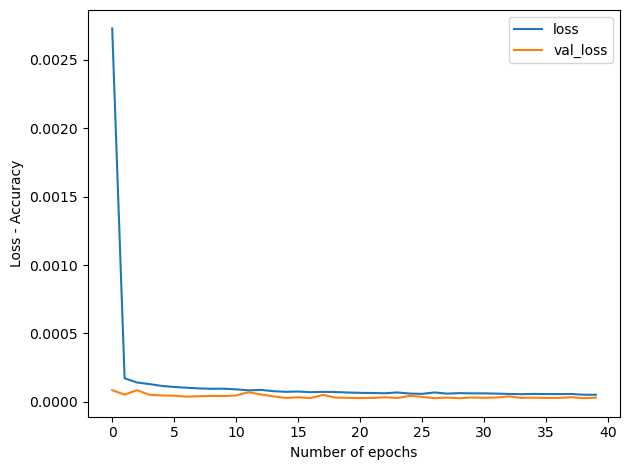

In [237]:
plot_training_history(fitted_multivariate_model)


67/67 [==============================] - 0s 3ms/step


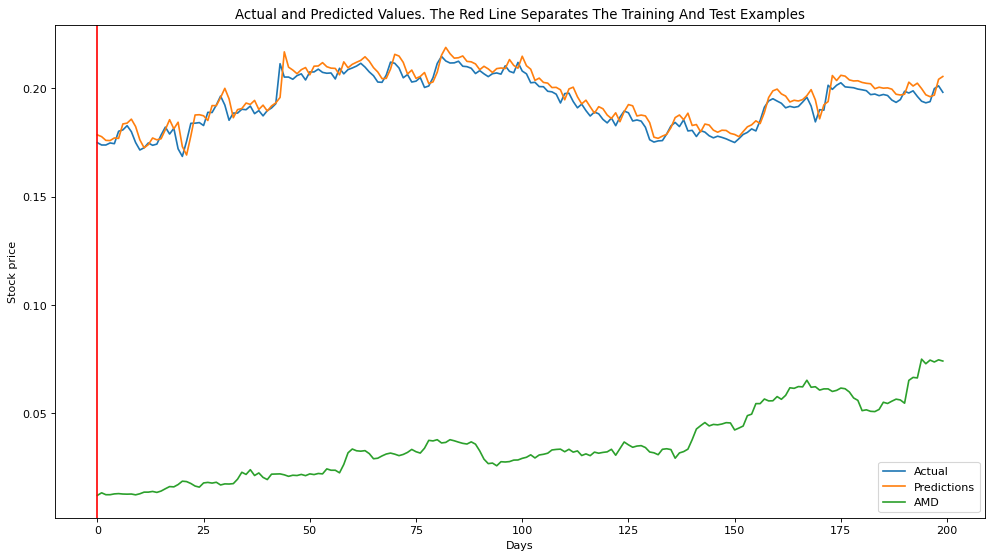

In [286]:
# Plotting actual stock prices and predictions
with tf.device('/cpu:0'):
    train_predict_m = fitted_multivariate_model.model.predict(
        X_train_combined)
    val_predict_m = fitted_multivariate_model.model.predict(X_val_combined)
    test_predict_m = fitted_multivariate_model.model.predict(X_test_combined)
plot_result(np.array([]), y_test_combined[500:700], np.array([]),
            test_predict_m[500:700], corresponding_y_amd_test[500:700])


In [284]:
print("Multivariate train MSE:", mean_squared_error(
    y_train_combined.reshape(y_train_combined.shape[0], 1), train_predict_m))
print("Multivariate val MSE:", mean_squared_error(
    y_val_combined.reshape(y_val_combined.shape[0], 1), val_predict_m))
print("Multivariate test MSE:", mean_squared_error(
    y_test_combined.reshape(y_test_combined.shape[0], 1), test_predict_m))


Multivariate train MSE: 6.653329837637987e-05
Multivariate val MSE: 3.059962241167059e-05


78/78 [==============================] - 0s 3ms/step


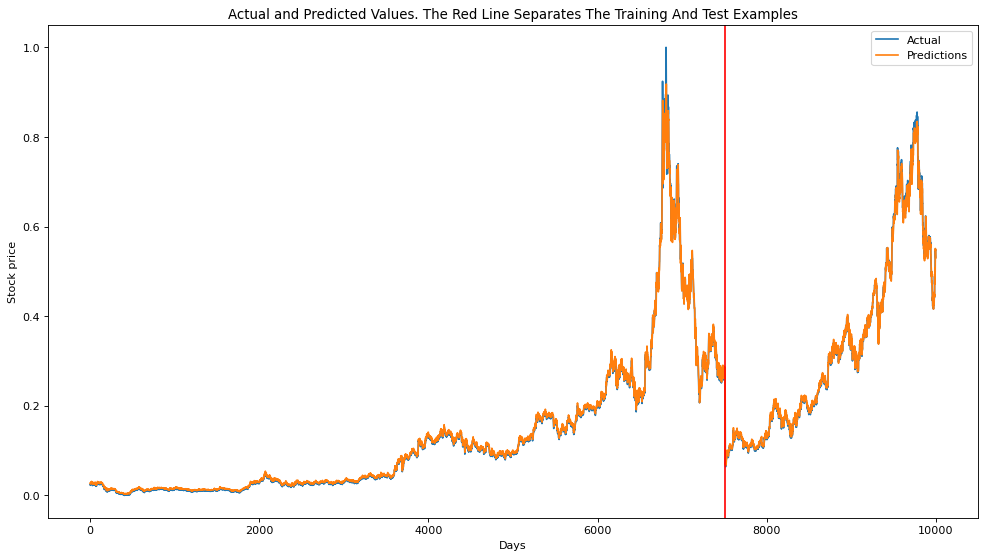

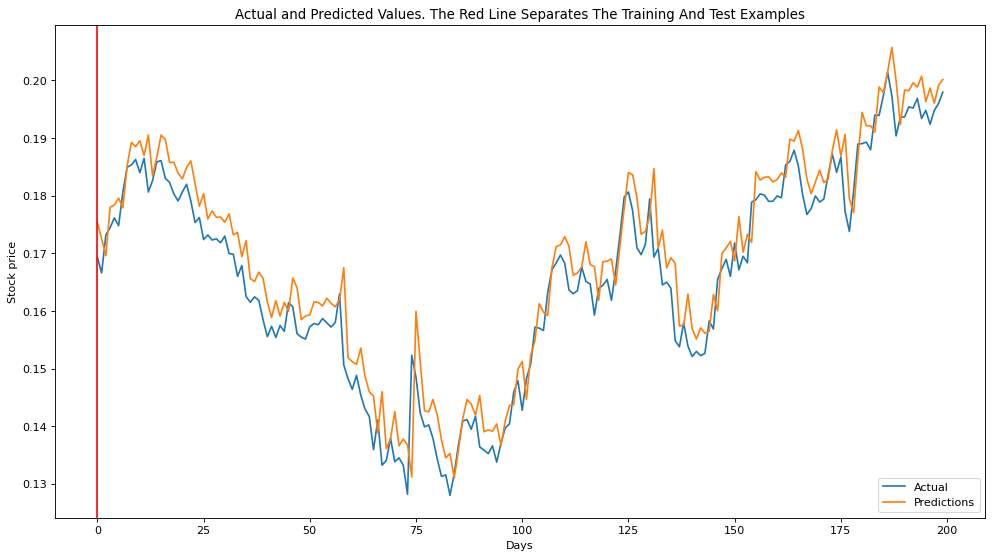

In [283]:
with tf.device('/cpu:0'):
    train_predict_optimized_gru_2 = fitted_optimized_gru_2.model.predict(
        X_train)
    test_predict_optimized_gru_2 = fitted_optimized_gru_2.model.predict(
        X_test)
plot_result(y_train, y_test, train_predict_optimized_gru_2,
            test_predict_optimized_gru_2)
plot_result(np.array([]), y_test[700:900], np.array([]),
            test_predict_optimized_gru_2[700:900])

78/78 [==============================] - 0s 2ms/step


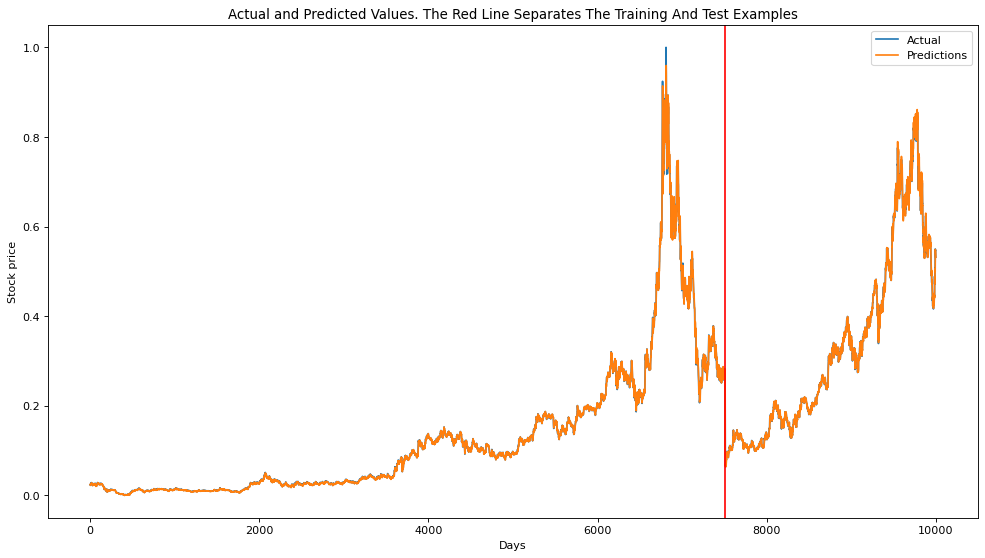

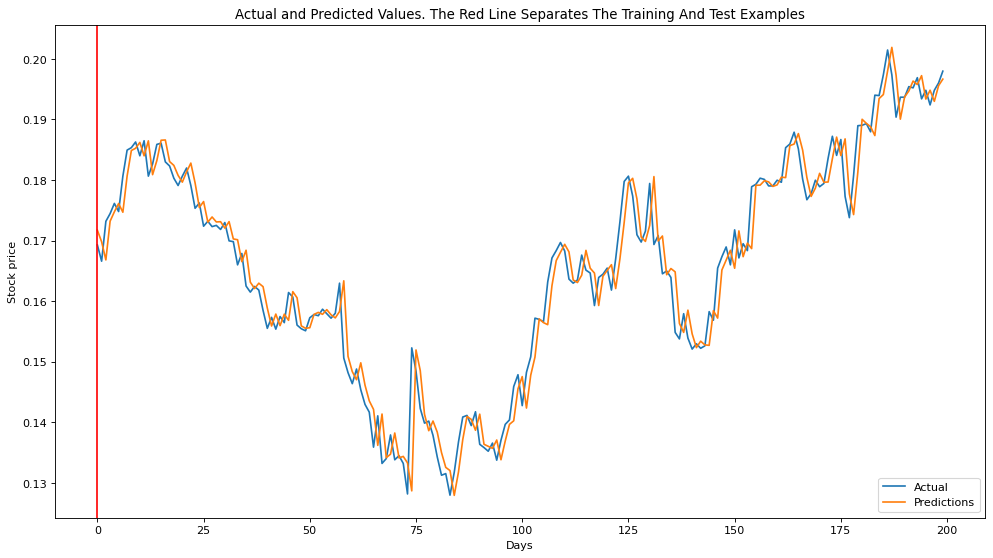

In [263]:
with tf.device('/cpu:0'):
    train_predict_optimized_gru_2 = fitted_optimized_gru_2.model.predict(X_train)
    test_predict_optimized_gru_2 = fitted_optimized_gru_2.model.predict(
        X_test)
plot_result(y_train, y_test, train_predict_optimized_gru_2,
            test_predict_optimized_gru_2)
plot_result(np.array([]), y_test[700:900], np.array([]),
            test_predict_optimized_gru_2[700:900])
